In [2]:
NAME = 'lstm-rusentiment'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

import datetime

import mydata as md

data = md.Data('drive/MyDrive/cache')


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [5]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('ru-sentiment')

In [6]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [7]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

In [8]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [9]:
train_ds_filtered = train_ds.filter(lambda x,y: tf.equal(len(x),1000))
valid_ds_filtered = valid_ds.filter(lambda x,y: tf.equal(len(x),1000))
test_ds_filtered = test_ds.filter(lambda x,y: tf.equal(len(x),1000))

In [10]:
#train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False).batch(64)
train_ds_batch=train_ds_filtered.batch(256)

valid_ds_batch=valid_ds_filtered.batch(256)
test_ds_batch=test_ds_filtered.batch(256)

In [11]:
 embedding_dim=64

 embedding_layer = tf.keras.layers.Embedding(
     input_dim=(max_features),
     output_dim=embedding_dim,
     mask_zero=True
 )
 bidirectional_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0))
 dense_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal')

 model = tf.keras.Sequential([
     keras.Input(shape=(1000,), dtype="int64"),
     embedding_layer,
     bidirectional_layer,
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
 ])
 model.summary()

 model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
               optimizer='rmsprop',
               metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                        

In [ ]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=False
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [12]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"

epochs = 10
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
742/742 [==============================] - 154s 193ms/step - loss: 0.6808 - accuracy: 0.6839 - f1_score: 0.6641 - val_loss: 0.5916 - val_accuracy: 0.7233 - val_f1_score: 0.6890
Epoch 2/10
742/742 [==============================] - 86s 115ms/step - loss: 0.5602 - accuracy: 0.7473 - f1_score: 0.7358 - val_loss: 0.5647 - val_accuracy: 0.7353 - val_f1_score: 0.7059
Epoch 3/10
742/742 [==============================] - 84s 113ms/step - loss: 0.5292 - accuracy: 0.7624 - f1_score: 0.7513 - val_loss: 0.5432 - val_accuracy: 0.7443 - val_f1_score: 0.7173
Epoch 4/10
742/742 [==============================] - 85s 115ms/step - loss: 0.5094 - accuracy: 0.7733 - f1_score: 0.7622 - val_loss: 0.5256 - val_accuracy: 0.7610 - val_f1_score: 0.7395
Epoch 5/10
742/742 [==============================] - 83s 112ms/step - loss: 0.4928 - accuracy: 0.7829 - f1_score: 0.7719 - val_loss: 0.5362 - val_accuracy: 0.7577 - val_f1_score: 0.7335
Epoch 6/10
742/742 [==============================] - 85s 114ms/

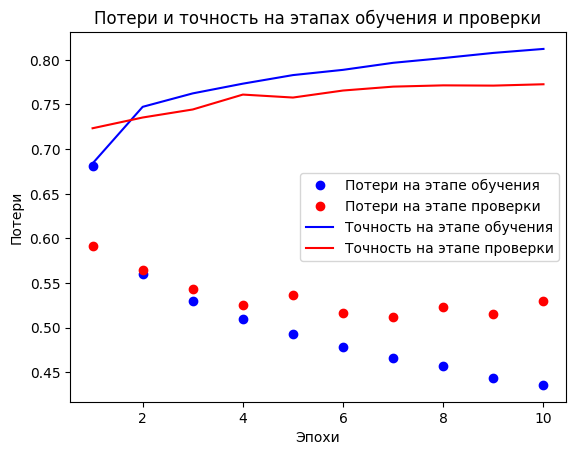

In [20]:
data.plot(history)

In [13]:
model.save(f"drive/MyDrive/models/model-{NAME}.keras")

In [14]:
raw_tab_train_ds, raw_tab_valid_ds, raw_tab_test_ds = data.load('tabiturient')

In [15]:
train_tab_ds = data.vectorize(raw_tab_train_ds, vectorize_layer)
valid_tab_ds = data.vectorize(raw_tab_valid_ds, vectorize_layer)
test_tab_ds = data.vectorize(raw_tab_test_ds, vectorize_layer)


In [16]:
model.evaluate(test_ds.batch(256))

42/42 [==============================] - 3s 58ms/step - loss: 0.5115 - accuracy: 0.7820 - f1_score: 0.7664


[0.5115034580230713, 0.7819698452949524, 0.7663965821266174]

In [19]:
model.evaluate(test_tab_ds.batch(256))

2/2 [==============================] - 0s 53ms/step - loss: 1.9511 - accuracy: 0.3611 - f1_score: 0.3296


[1.951140284538269, 0.3611111044883728, 0.329576700925827]

In [21]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

In [22]:
history = model.fit(
    train_tab_ds.batch(16),
    validation_data=valid_tab_ds.batch(16),
    epochs=10
)

Epoch 1/10
180/180 [==============================] - 52s 239ms/step - loss: 1.6077 - accuracy: 0.4019 - f1_score: 0.3875 - val_loss: 1.2465 - val_accuracy: 0.4568 - val_f1_score: 0.4536
Epoch 2/10
180/180 [==============================] - 11s 63ms/step - loss: 1.1674 - accuracy: 0.4910 - f1_score: 0.4875 - val_loss: 1.0028 - val_accuracy: 0.5097 - val_f1_score: 0.4952
Epoch 3/10
180/180 [==============================] - 12s 66ms/step - loss: 1.0449 - accuracy: 0.5421 - f1_score: 0.5197 - val_loss: 0.9054 - val_accuracy: 0.5571 - val_f1_score: 0.5099
Epoch 4/10
180/180 [==============================] - 12s 65ms/step - loss: 0.9678 - accuracy: 0.5845 - f1_score: 0.5425 - val_loss: 0.8773 - val_accuracy: 0.6045 - val_f1_score: 0.5485
Epoch 5/10
180/180 [==============================] - 12s 66ms/step - loss: 0.9025 - accuracy: 0.6026 - f1_score: 0.5528 - val_loss: 0.8505 - val_accuracy: 0.6212 - val_f1_score: 0.5545
Epoch 6/10
180/180 [==============================] - 12s 65ms/step -

In [24]:
model.evaluate(test_tab_ds.batch(256))

2/2 [==============================] - 0s 59ms/step - loss: 0.7706 - accuracy: 0.6694 - f1_score: 0.6069


[0.7706312537193298, 0.6694444417953491, 0.6069130301475525]

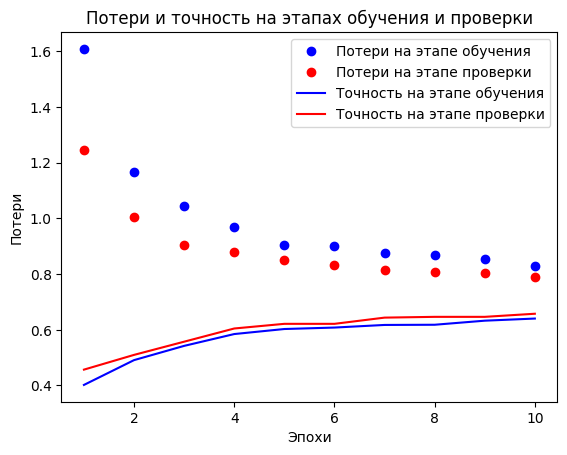

In [23]:
data.plot(history)